# Building an Automated Pipeline for Amazon Forecast
When a file is put in S3 with data for training, build a pipeline that automatically performs data import, training, forecasting, and exporting of predictions in Amazon Forecast.
We use Step Functions and Lambda.

# Configure SageMaker role
Attach policies for the services you use and also set up trust relationships, as shown in the figure below.

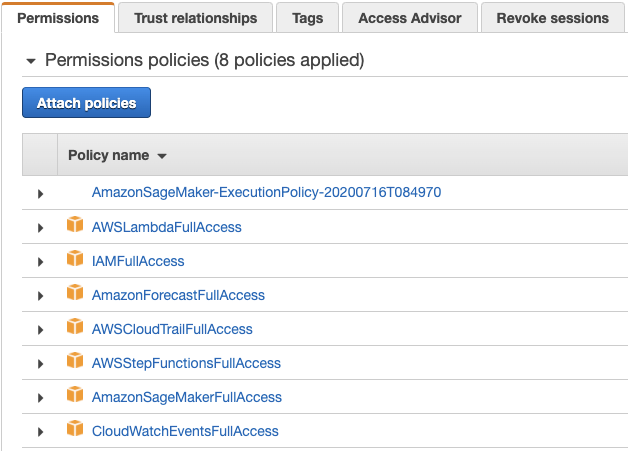

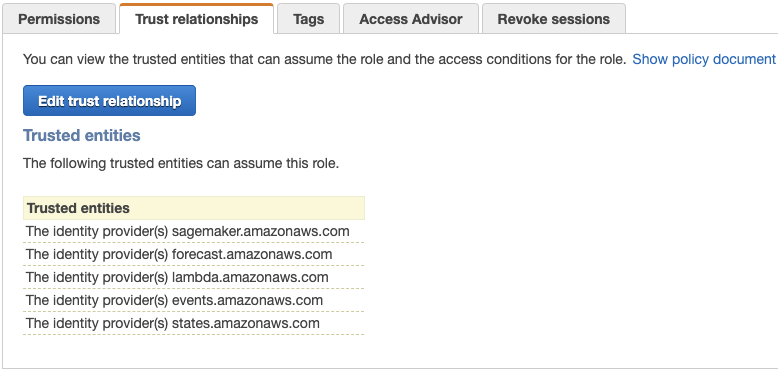

Edit trust relationship should be written as follows.

In [ ]:
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "sagemaker.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "forecast.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "lambda.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "events.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "states.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

## Getting SageMaker role

In [2]:
from sagemaker import get_execution_role

role_sm = get_execution_role()

In [3]:
role_sm

'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970'

# 1.make Lambda function
We will create a Lambda function. The files we will use are located in lambdas/.

In [4]:
import boto3

In [5]:
lambda_ = boto3.client('lambda')

In [6]:
!rm -f lambdas/createdatasetimport/datasetimport.zip
!cd lambdas/createdatasetimport; zip -r datasetimport .

zip_file = open("lambdas/createdatasetimport/datasetimport.zip", "rb").read()


lambda_.create_function(
    FunctionName="datasetimport",
    Runtime="python3.7",
    Role=role_sm,
    Handler="datasetimport.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: datasetimport.py (deflated 54%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/datasetimport-checkpoint.py (deflated 54%)


{'ResponseMetadata': {'RequestId': 'b8e8a0a8-6e02-4fd9-8d38-30ff53d2c25e',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:52 GMT',
   'content-type': 'application/json',
   'content-length': '894',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b8e8a0a8-6e02-4fd9-8d38-30ff53d2c25e'},
  'RetryAttempts': 0},
 'FunctionName': 'datasetimport',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:datasetimport',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'datasetimport.lambda_handler',
 'CodeSize': 1330,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:52.647+0000',
 'CodeSha256': 'P47rcfB7XT6dDj39frr5mxCXXh4FXhNI9XVkTfvIwoU=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '205eda86-1cbb-4dfe-813b-20e25adfadfd',
 'State': 'Active',
 'LastUpdateStatus': 'Successful'}

In [7]:
!rm -f lambdas/GetStatusImport/getstatusimport.zip
!cd lambdas/GetStatusImport; zip -r getstatusimport .

zip_file = open("lambdas/GetStatusImport/getstatusimport.zip", "rb").read()

lambda_.create_function(
    FunctionName="getstatusimport",
    Runtime="python3.7",
    Role=role_sm,
    Handler="getstatusimport.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/getstatusimport-checkpoint.py (deflated 46%)
  adding: getstatusimport.py (deflated 46%)


{'ResponseMetadata': {'RequestId': '1b28316a-7cda-4f1e-a2be-1fd959a8af76',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:53 GMT',
   'content-type': 'application/json',
   'content-length': '899',
   'connection': 'keep-alive',
   'x-amzn-requestid': '1b28316a-7cda-4f1e-a2be-1fd959a8af76'},
  'RetryAttempts': 0},
 'FunctionName': 'getstatusimport',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:getstatusimport',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'getstatusimport.lambda_handler',
 'CodeSize': 976,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:53.458+0000',
 'CodeSha256': 'DYiTr0rxzfBLKowMZAtq08fuZqn5OdWcceFyHb30qMw=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': 'cd65d525-fb75-44f0-83bc-305f49226244',
 'State': 'Active',
 'LastUpdateStatus': 'Successful'}

In [8]:
!rm -f lambdas/createpredictor/predictor.zip
!cd lambdas/createpredictor; zip -r predictor .

zip_file = open("lambdas/createpredictor/predictor.zip", "rb").read()

lambda_.create_function(
    FunctionName="predictor",
    Runtime="python3.7",
    Role=role_sm,
    Handler="predictor.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/predictor-checkpoint.py (deflated 56%)
  adding: predictor.py (deflated 56%)


{'ResponseMetadata': {'RequestId': 'ba00a770-e94e-4a29-a51c-7be620218b44',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:54 GMT',
   'content-type': 'application/json',
   'content-length': '882',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ba00a770-e94e-4a29-a51c-7be620218b44'},
  'RetryAttempts': 0},
 'FunctionName': 'predictor',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:predictor',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'predictor.lambda_handler',
 'CodeSize': 1494,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:54.243+0000',
 'CodeSha256': 'nH8tPBarm6d0nTUcFJ+Tq6UFR8GqB6EQ0ng87KJLSak=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '6007b6d1-36b7-4367-922d-093e7d5288c1',
 'State': 'Active',
 'LastUpdateStatus': 'Successful'}

In [9]:
!rm -f lambdas/GetStatusPredictor/getstatuspredictor.zip
!cd lambdas/GetStatusPredictor; zip -r getstatuspredictor .

zip_file = open("lambdas/GetStatusPredictor/getstatuspredictor.zip", "rb").read()

lambda_.create_function(
    FunctionName="getstatuspredictor",
    Runtime="python3.7",
    Role=role_sm,
    Handler="getstatuspredictor.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: getstatuspredictor.py (deflated 46%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/getstatuspredictor-checkpoint.py (deflated 46%)


{'ResponseMetadata': {'RequestId': '2ca5aadb-854c-48de-9089-243df1867471',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:55 GMT',
   'content-type': 'application/json',
   'content-length': '908',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2ca5aadb-854c-48de-9089-243df1867471'},
  'RetryAttempts': 0},
 'FunctionName': 'getstatuspredictor',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:getstatuspredictor',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'getstatuspredictor.lambda_handler',
 'CodeSize': 968,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:55.108+0000',
 'CodeSha256': 'HlXufgLTI6LeRialDjUbhhjPhXAdJxfssnRcjdQKLIk=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': 'cf40df18-3bb0-4e1c-8e75-99a8961c7f4a',
 'State': 'Active',
 'LastUpdateStatus': 'Succe

In [10]:
!rm -f lambdas/createforecast/forecast.zip
!cd lambdas/createforecast; zip -r forecast .

zip_file = open("lambdas/createforecast/forecast.zip", "rb").read()

lambda_.create_function(
    FunctionName="forecast",
    Runtime="python3.7",
    Role=role_sm,
    Handler="forecast.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/forecast-checkpoint.py (deflated 45%)
  adding: forecast.py (deflated 45%)


{'ResponseMetadata': {'RequestId': 'd6f82f34-bf83-436f-b9a5-8a0d02bc2946',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:56 GMT',
   'content-type': 'application/json',
   'content-length': '878',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd6f82f34-bf83-436f-b9a5-8a0d02bc2946'},
  'RetryAttempts': 0},
 'FunctionName': 'forecast',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:forecast',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'forecast.lambda_handler',
 'CodeSize': 952,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:56.379+0000',
 'CodeSha256': 'YMDIz+T6wW8nGpsBvx5B5alqOsBgC/ggCoiMkhd+k3w=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '06d51339-fc21-4ff0-a734-c593a1ca90ea',
 'State': 'Active',
 'LastUpdateStatus': 'Successful'}

In [11]:
!rm -f lambdas/GetStatusForecast/getstatusforecast.zip
!cd lambdas/GetStatusForecast; zip -r getstatusforecast .

zip_file = open("lambdas/GetStatusForecast/getstatusforecast.zip", "rb").read()

lambda_.create_function(
    FunctionName="getstatusforecast",
    Runtime="python3.7",
    Role=role_sm,
    Handler="getstatusforecast.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: getstatusforecast.py (deflated 47%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/getstatusforecast-checkpoint.py (deflated 47%)


{'ResponseMetadata': {'RequestId': '7ba988a1-da5e-46f7-ba4f-ac7c7bc42afa',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:57 GMT',
   'content-type': 'application/json',
   'content-length': '905',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7ba988a1-da5e-46f7-ba4f-ac7c7bc42afa'},
  'RetryAttempts': 0},
 'FunctionName': 'getstatusforecast',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:getstatusforecast',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'getstatusforecast.lambda_handler',
 'CodeSize': 952,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:57.399+0000',
 'CodeSha256': 'Ch+NQ2pS7PM9WanmFv0y01E7nNcZYe3+jSIJO4XSP5w=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '2f8c114b-6602-4b81-936f-59372dd1c0c8',
 'State': 'Active',
 'LastUpdateStatus': 'Successf

In [12]:
!rm -f lambdas/createforecastexportjob/forecastexportjob.zip
!cd lambdas/createforecastexportjob; zip -r forecastexportjob .

zip_file = open("lambdas/createforecastexportjob/forecastexportjob.zip", "rb").read()

lambda_.create_function(
    FunctionName="forecastexportjob",
    Runtime="python3.7",
    Role=role_sm,
    Handler="forecastexportjob.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: forecastexportjob.py (deflated 53%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/forecastexportjob-checkpoint.py (deflated 53%)


{'ResponseMetadata': {'RequestId': '2712b171-258b-434a-81b1-a0bc84906ed9',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:58 GMT',
   'content-type': 'application/json',
   'content-length': '906',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2712b171-258b-434a-81b1-a0bc84906ed9'},
  'RetryAttempts': 0},
 'FunctionName': 'forecastexportjob',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:forecastexportjob',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'forecastexportjob.lambda_handler',
 'CodeSize': 1220,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:58.327+0000',
 'CodeSha256': 'W+G/uY3Bji6ScPwrx/SEAEmF84oQaAd30/TmqBLPzQ8=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '6b1484fc-40d6-476a-97b8-657cc9771848',
 'State': 'Active',
 'LastUpdateStatus': 'Success

In [13]:
!rm -f lambdas/GetStatusForecastExportJob/getstatusforecastexportjob.zip
!cd lambdas/GetStatusForecastExportJob; zip -r getstatusforecastexportjob .

zip_file = open("lambdas/GetStatusForecastExportJob/getstatusforecastexportjob.zip", "rb").read()

lambda_.create_function(
    FunctionName="getstatusforecastexportjob",
    Runtime="python3.7",
    Role=role_sm,
    Handler="getstatusforecastexportjob.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: getstatusforecastexportjob.py (deflated 47%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/getstatusforecastexportjob-checkpoint.py (deflated 47%)


{'ResponseMetadata': {'RequestId': '1ef08e6f-e78b-4cea-90f1-892e1a4012e6',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:03:59 GMT',
   'content-type': 'application/json',
   'content-length': '933',
   'connection': 'keep-alive',
   'x-amzn-requestid': '1ef08e6f-e78b-4cea-90f1-892e1a4012e6'},
  'RetryAttempts': 0},
 'FunctionName': 'getstatusforecastexportjob',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:getstatusforecastexportjob',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'getstatusforecastexportjob.lambda_handler',
 'CodeSize': 1016,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:03:59.255+0000',
 'CodeSha256': 'YH0yPEoSN3LXDonPSrv4tslR1FWN4LOMIYUnQIZSN2I=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': 'a2150e84-c39b-4a2a-b1b2-b68bde7ecea9',
 'State': 'Active',
 '

In [14]:
!rm -f lambdas/NotifyUser/notifyuser.zip
!cd lambdas/NotifyUser; zip -r notifyuser .

zip_file = open("lambdas/NotifyUser/notifyuser.zip", "rb").read()

lambda_.create_function(
    FunctionName="notifyuser",
    Runtime="python3.7",
    Role=role_sm,
    Handler="notifyuser.lambda_handler",
    Code={"ZipFile": zip_file},
    Timeout=60*15,
    MemorySize=3008
)

  adding: notifyuser.py (deflated 12%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/notifyuser-checkpoint.py (deflated 12%)


{'ResponseMetadata': {'RequestId': '7d09473b-8213-4317-be9b-3092fde879cc',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Thu, 30 Jul 2020 18:04:00 GMT',
   'content-type': 'application/json',
   'content-length': '884',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7d09473b-8213-4317-be9b-3092fde879cc'},
  'RetryAttempts': 0},
 'FunctionName': 'notifyuser',
 'FunctionArn': 'arn:aws:lambda:us-east-1:805433377179:function:notifyuser',
 'Runtime': 'python3.7',
 'Role': 'arn:aws:iam::805433377179:role/service-role/AmazonSageMaker-ExecutionRole-20200716T084970',
 'Handler': 'notifyuser.lambda_handler',
 'CodeSize': 730,
 'Description': '',
 'Timeout': 900,
 'MemorySize': 3008,
 'LastModified': '2020-07-30T18:04:00.174+0000',
 'CodeSha256': 'MqMb9SF/FtdXPWN/c3vBpxpo5FfMVdfS6idTCtllhN8=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '4557d994-edf6-4f62-9c9c-322a2aa031ed',
 'State': 'Active',
 'LastUpdateStatus': 'Successful'}

# 2. Step Functins: Create state machine
The definition of the state machine is created, and the creation of the state machine is performed based on the definition.

In [15]:
import sagemaker

In [16]:
sagemaker_session = sagemaker.Session()

In [17]:
sagemaker_session.boto_region_name

'us-east-1'

In [18]:
sts = boto3.client('sts')
id_info = sts.get_caller_identity()

In [19]:
id_info['Account']

'805433377179'

In [20]:
import json

In [21]:
def_sfn={
  "Comment": "Amazon Forecast example of the Amazon States Language using an AWS Lambda Function",
  "StartAt": "datasetimport",
  "States": {
    "datasetimport": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:datasetimport",
      "ResultPath":"$",
      "Next": "GetStatusImport"
    },
    "GetStatusImport": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:getstatusimport",
      "ResultPath":"$",
      "Next": "CheckStatusImport"
    },
    "CheckStatusImport": {
        "Type": "Choice",
        "InputPath":"$",
        "Choices": [
        {
        "Variable": "$.is_active_import",
        "BooleanEquals": True,
        "Next": "predictor"
        }
        ],
        "Default": "SleepCheckStatusImport"
        },
    "SleepCheckStatusImport": {
        "Type": "Wait",
        "Seconds": 300,
        "Next": "GetStatusImport"
    },
    "predictor": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:predictor",
      "ResultPath":"$",
      "Next": "GetStatusPredictor"
    },
    "GetStatusPredictor": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:getstatuspredictor",
      "ResultPath":"$",
      "Next": "CheckStatusPredictor"
    },
    "CheckStatusPredictor": {
        "Type": "Choice",
        "InputPath":"$",
        "Choices": [
        {
        "Variable": "$.is_active_predictor",
        "BooleanEquals": True,
        "Next": "forecast"
        }
        ],
        "Default": "SleepCheckStatusPredictor"
        },
    "SleepCheckStatusPredictor": {
        "Type": "Wait",
        "Seconds": 300,
        "Next": "GetStatusPredictor"
    },
    "forecast": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:forecast",
      "ResultPath":"$",
      "Next": "GetStatusForecast"
    },
    "GetStatusForecast": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:getstatusforecast",
      "ResultPath":"$",
      "Next": "CheckStatusForecast"
    },  
    "CheckStatusForecast": {
        "Type": "Choice",
        "InputPath":"$",
        "Choices": [
        {
        "Variable": "$.is_active_forecast",
        "BooleanEquals": True,
        "Next": "forecastexportjob"
        }
        ],
        "Default": "SleepCheckStatusForecast"
        },
    "SleepCheckStatusForecast": {
        "Type": "Wait",
        "Seconds": 300,
        "Next": "GetStatusForecast"
    },
    "forecastexportjob": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:forecastexportjob",
      "ResultPath":"$",
      "Next": "GetStatusForecastExportjob"
    },
    "GetStatusForecastExportjob": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:getstatusforecastexportjob",
      "ResultPath":"$",
      "Next": "CheckStatusExport"
    },  
    "CheckStatusExport": {
        "Type": "Choice",
        "InputPath":"$",
        "Choices": [
        {
        "Variable": "$.is_active_export",
        "BooleanEquals": True,
        "Next": "NotifyUser"
        }
        ],
        "Default": "SleepCheckStatusExport"
        },
    "SleepCheckStatusExport": {
        "Type": "Wait",
        "Seconds": 300,
        "Next": "GetStatusForecastExportjob"
    },
    "NotifyUser": {
      "Type": "Task",
      "InputPath":"$",
      "Resource": "arn:aws:lambda:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":function:notifyuser",
      "ResultPath":"$",
      "End": True
    }
  }
}


In [22]:
with open('./definition.json', 'w') as f:
    json.dump(def_sfn, f, indent=2, ensure_ascii=False)

In [23]:
import boto3
sfn = boto3.client('stepfunctions')

In [24]:
sfn.create_state_machine(
        name="demo-forecast",
        definition=open("definition.json").read(),
        roleArn=role_sm
)

{'stateMachineArn': 'arn:aws:states:us-east-1:805433377179:stateMachine:demo-forecast',
 'creationDate': datetime.datetime(2020, 7, 30, 18, 4, 24, 793000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'c82d7d66-9fba-4ee2-89aa-a42f7de90218',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c82d7d66-9fba-4ee2-89aa-a42f7de90218',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '118'},
  'RetryAttempts': 0}}

# 3.AWS CloudTrail :create trail  
https://docs.aws.amazon.com/step-functions/latest/dg/tutorial-cloudwatch-events-s3.html

Configure CloudTrail and CloudWatch Events to run Step Functions by triggering S3 object placement as described in this guide.

https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/cloudtrail.html#CloudTrail.Client.create_trail

In [25]:
! pip freeze | grep boto3

boto3==1.14.16


In [26]:
cloudtrail = boto3.client('cloudtrail')

In [27]:
sts = boto3.client('sts')
id_info = sts.get_caller_identity()
print(id_info['Account'])

805433377179


In [28]:
bucket_name = 'demo-forecast-' + id_info['Account']

In [29]:
bucket_name

'demo-forecast-805433377179'

In [30]:
output_trail_bucket = bucket_name + '-trail'

In [31]:
s3 = boto3.client('s3')
s3.create_bucket(Bucket=output_trail_bucket)

{'ResponseMetadata': {'RequestId': 'E7868CF8382E3819',
  'HostId': '0Na+5a/2hW1rjMSlZ12iRI/5FhtVR/u6xAqyEcZivaHmqYlHzxMLhfEv2zQBCjYO9HWakvGAYFk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '0Na+5a/2hW1rjMSlZ12iRI/5FhtVR/u6xAqyEcZivaHmqYlHzxMLhfEv2zQBCjYO9HWakvGAYFk=',
   'x-amz-request-id': 'E7868CF8382E3819',
   'date': 'Thu, 30 Jul 2020 18:05:43 GMT',
   'location': '/demo-forecast-805433377179-trail',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/demo-forecast-805433377179-trail'}

## set bucket policy
setting policy with boto3  
https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-bucket-policies.html

In [32]:
import json

In [33]:
bucket_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AWSCloudTrailAclCheck20150319",
            "Effect": "Allow",
            "Principal": {
                "Service": "cloudtrail.amazonaws.com"
            },
            "Action": "s3:GetBucketAcl",
            "Resource": "arn:aws:s3:::" + bucket_name + "-trail"
        },
        {
            "Sid": "AWSCloudTrailWrite20150319",
            "Effect": "Allow",
            "Principal": {
                "Service": "cloudtrail.amazonaws.com"
            },
            "Action": "s3:PutObject",
            "Resource": "arn:aws:s3:::" + bucket_name + "-trail/AWSLogs/" + id_info['Account'] + "/*",
            "Condition": {
                "StringEquals": {
                    "s3:x-amz-acl": "bucket-owner-full-control"
                }
            }
        }
    ]
}

# Convert the policy from JSON dict to string
bucket_policy = json.dumps(bucket_policy)

In [34]:
# Set the new policy
s3 = boto3.client('s3')
s3.put_bucket_policy(Bucket=output_trail_bucket, Policy=bucket_policy)

{'ResponseMetadata': {'RequestId': 'E3AE3B4C61146208',
  'HostId': 'JBTfaVMVZwD3bY90CJiiWS3phh47GKCcEOwz0Xtu+kl+yFFSmlfuC0xzBBveSMfuPDJOYj5GQNE=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'JBTfaVMVZwD3bY90CJiiWS3phh47GKCcEOwz0Xtu+kl+yFFSmlfuC0xzBBveSMfuPDJOYj5GQNE=',
   'x-amz-request-id': 'E3AE3B4C61146208',
   'date': 'Thu, 30 Jul 2020 18:06:14 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [35]:
cloudtrail.create_trail(
    Name='forecast-trail',
    S3BucketName=output_trail_bucket,
    EnableLogFileValidation=True
)

{'Name': 'forecast-trail',
 'S3BucketName': 'demo-forecast-805433377179-trail',
 'IncludeGlobalServiceEvents': True,
 'IsMultiRegionTrail': False,
 'TrailARN': 'arn:aws:cloudtrail:us-east-1:805433377179:trail/forecast-trail',
 'LogFileValidationEnabled': True,
 'IsOrganizationTrail': False,
 'ResponseMetadata': {'RequestId': '84a4caf7-729e-4279-b43e-e8f394ad19a9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '84a4caf7-729e-4279-b43e-e8f394ad19a9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '272',
   'date': 'Thu, 30 Jul 2020 18:06:13 GMT'},
  'RetryAttempts': 0}}

In [36]:
cloudtrail.put_event_selectors(
    TrailName='forecast-trail',
    EventSelectors=[
        {
            'ReadWriteType': 'All',
            'IncludeManagementEvents': True,
            'DataResources': [
                {
                    'Type': 'AWS::S3::Object',
                    'Values': [
                        f'arn:aws:s3:::{bucket_name}/',
                    ]
                },
            ]
        },
    ]
)

{'TrailARN': 'arn:aws:cloudtrail:us-east-1:805433377179:trail/forecast-trail',
 'EventSelectors': [{'ReadWriteType': 'All',
   'IncludeManagementEvents': True,
   'DataResources': [{'Type': 'AWS::S3::Object',
     'Values': ['arn:aws:s3:::demo-forecast-805433377179/']}],
   'ExcludeManagementEventSources': []}],
 'ResponseMetadata': {'RequestId': '92f23099-bc88-4d96-9d8b-10bb4191ffe6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '92f23099-bc88-4d96-9d8b-10bb4191ffe6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '285',
   'date': 'Thu, 30 Jul 2020 18:06:14 GMT'},
  'RetryAttempts': 0}}

### enable logging
https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/cloudtrail.html#CloudTrail.Client.start_logging

In [37]:
cloudtrail.start_logging(Name='forecast-trail')

{'ResponseMetadata': {'RequestId': '7c5bd36f-d87b-41b4-a250-22e834a7ad2d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7c5bd36f-d87b-41b4-a250-22e834a7ad2d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Thu, 30 Jul 2020 18:06:17 GMT'},
  'RetryAttempts': 0}}

# 4.CloudWatch Event: build a rule
https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/events.html


put_rule(): create rule  
https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/events.html#CloudWatchEvents.Client.put_rule


In [38]:
bucket_name

'demo-forecast-805433377179'

In [39]:
cwe = boto3.client('events')

In [40]:
ep_str ='{"source":["aws.s3"], \
        "detail-type":["AWS API Call via CloudTrail"], \
        "detail":{"eventSource":["s3.amazonaws.com"], \
        "eventName":["PutObject", "CompleteMultipartUpload"], \
        "requestParameters":{"bucketName":["'+ bucket_name + '"]}}}'

In [41]:
cwe.put_rule(
    Name='demo-forecast',
    EventPattern=ep_str,
    State='ENABLED'
)

{'RuleArn': 'arn:aws:events:us-east-1:805433377179:rule/demo-forecast',
 'ResponseMetadata': {'RequestId': '702807c0-00ce-45f1-a8ae-fa749d34ab5d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '702807c0-00ce-45f1-a8ae-fa749d34ab5d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '70',
   'date': 'Thu, 30 Jul 2020 18:06:22 GMT'},
  'RetryAttempts': 0}}

In [42]:
cwe.put_targets(
    Rule='demo-forecast',
    Targets=[
        {
            'Id': 'forecast',
            'Arn': "arn:aws:states:" + sagemaker_session.boto_region_name + ":" + id_info['Account'] + ":stateMachine:demo-forecast",
            'RoleArn': role_sm
        }
    ]
)

{'FailedEntryCount': 0,
 'FailedEntries': [],
 'ResponseMetadata': {'RequestId': 'dad0cb4f-97e3-4494-a6ac-3d672d41109f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dad0cb4f-97e3-4494-a6ac-3d672d41109f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '41',
   'date': 'Thu, 30 Jul 2020 18:06:22 GMT'},
  'RetryAttempts': 0}}

# 5.Put additional file into S3
When upload a file to S3, Step Functions runs.

In [43]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

bucket.upload_file('./output/tr_target_add_20091201_20101209.csv', 'input/tr_target_add_20091201_20101209.csv')

# 6.Next
When Step Functions is completed, the prediction results are output to S3, import the data source in QuickSight using the same procedure as before and visualize it.